In [1]:
#!pip3 install --upgrade gym
#!pip3 install --upgrade box2d-py
#!pip3 install opencv-python
#from gym.envs.box2d.car_dynamics import Car

array([0.2187804 , 0.7549155 , 0.46578676], dtype=float32)

In [4]:
#env=gym.make('CarRacing-v0')
#env.action_space
#env.action_space.sample()

In [5]:

envc.reset()
nst,rw,ter,info=envc.step([0,1,0])

Track generation: 1072..1344 -> 272-tiles track


In [4]:


def env_step(env,action):
    plt.cla()
    frame=np.zeros((100,200,3),dtype=np.uint8)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    nst,rw,ter,info=envc.step(action) # take a random action
    frame[0:96,0:96,:]=np.array(nst)
    
    pos=envc.car.hull.position
    vel=np.sqrt(envc.car.hull.linearVelocity[0]**2+envc.car.hull.linearVelocity[1]**2)
    ang=envc.car.hull.angle
    
    img = cv2.putText(np.array(frame), 'vel %f'%vel, (100,10), font,.3, (255,255,0),1, cv2.LINE_AA)
    img = cv2.putText(np.array(img), 'ang %f'%ang, (100,20), font,.3, (255,0,255),1, cv2.LINE_AA)
    image = cv2.putText(np.array(img), 'x,y %f,%f'%(pos[0],pos[1]), (100,30), font,.2, (255,0,255),1, cv2.LINE_AA)
        
    plt.imshow(image)
    plt.show()
    plt.pause(0.0001)
        
    return [pos[0],pos[1],vel,ang],rw,ter,info
#envc.close()

In [17]:
%matplotlib tk

import gym
from matplotlib import pyplot as plt
import cv2
import numpy as np
from car_env import CarRacing
import time

envc=CarRacing()
envc.action_space
envc.action_space.sample()

envc.reset()
envc.track=track
points=[[x,y] for a,b,x,y in envc.track]
points=np.array(points)
plt.plot(points[:,0],points[:,1])
plt.show()
for i in range(100):
    st,rw,ter,info=env_step(envc,[0,1,0])
    time.sleep(0.1)
    print(st)
envc.close()

Track generation: 1307..1638 -> 331-tiles track
[219.613525390625, -54.187110900878906, 2.1912044458357367, -0.09481491893529892]
[219.62002563476562, -54.11946105957031, 3.39810159628121, -0.09479337930679321]
[219.6282958984375, -54.03271484375, 4.357076101507715, -0.09477635473012924]
[219.6382598876953, -53.92811584472656, 5.253584379464844, -0.09476357698440552]
[219.64988708496094, -53.80598068237305, 6.1343549051683075, -0.09475281834602356]
[219.6631622314453, -53.666385650634766, 7.011162765942653, -0.09474349021911621]
[219.6781005859375, -53.50935363769531, 7.886970786667174, -0.09473515301942825]
[219.69468688964844, -53.33488845825195, 8.762527088676324, -0.09472746402025223]
[219.7129364013672, -53.14299392700195, 9.638021502681859, -0.09472043067216873]
[219.7328338623047, -52.93366622924805, 10.513498321682917, -0.09471361339092255]
[219.75436401367188, -52.7069091796875, 11.388971713036371, -0.09470752626657486]
[219.77757263183594, -52.46271896362305, 12.2644434006044

In [16]:
plt.plot(points[:,0]+150,points[:,1]+150)
plt.show()

In [14]:
import pickle
save=False
if save==True:
    f=open('path-1','wb')
    pickle.dump(envc.track,f)
    f.close()
f=open('path-1','rb')
track=pickle.load(f)
f.close()
track

[(-0.26093213864160614,
  -0.10156726652590482,
  219.4345269665759,
  -55.01666273933693),
 (-0.24565635882343972,
  -0.10156726652590482,
  219.78940152198956,
  -51.53470006723374),
 (-0.2303125673331481,
  -0.10156726652590482,
  220.14427607740322,
  -48.052737395130556),
 (-0.2149075788500685,
  -0.10156726652590482,
  220.49915063281688,
  -44.57077472302737),
 (-0.19944837859876774,
  -0.10156726652590482,
  220.85402518823054,
  -41.08881205092418),
 (-0.18394210460537508,
  -0.10156726652590482,
  221.2088997436442,
  -37.606849378820996),
 (-0.16839602889744842,
  -0.10156726652590482,
  221.56377429905785,
  -34.12488670671781),
 (-0.1528175377637675,
  -0.10156726652590482,
  221.9186488544715,
  -30.642924034614623),
 (-0.13721411120258775,
  -0.10156726652590482,
  222.27352340988517,
  -27.160961362511436),
 (-0.12159330169749882,
  -0.10156726652590482,
  222.62839796529883,
  -23.67899869040825),
 (-0.10596271246899924,
  -0.10156726652590482,
  222.9832725207125,
  -

In [ ]:
cv2.imwrite(data)

In [8]:
#https://navoshta.com/detecting-road-features/
#https://towardsdatascience.com/tutorial-build-a-lane-detector-679fd8953132
#https://towardsdatascience.com/finding-lane-lines-simple-pipeline-for-lane-detection-d02b62e7572b

In [4]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt

In [8]:
class image_to_traj():
    def __init__(self,N=10):
        self.N=N
    #@property
    def run(self,image):
        canny = self.do_canny(image)
        segment = self.do_segment(canny)
        ret= self.get_points(segment)
        return ret
        #hough = cv2.HoughLinesP(segment, 1, np.pi / 180, 10, np.array([]), minLineLength = 5, maxLineGap = 5)
    def do_canny(self,image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        canny = cv2.Canny(blur, 50, 150)
        return canny

    def do_segment(self,img):
        height = img.shape[0]
        polygons = np.array([
                                [(0, 80), (96, 80), (0, 0),(96,0)]
                            ])
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, polygons, 255)
        segment = cv2.bitwise_and(img, mask)
        return segment

    def get_points(self,segment):
        crops=[]
        cxs=[]
        _cys=[]
        cys=[]
        offset=self.N//2
        height=segment.shape[1]
        for i in range(height//self.N):
            crop=segment[i*self.N:(i+1)*self.N,:]
            crops.append(crop)
            M=cv2.moments(crop)
            try:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
            except:
                pass
                #cx=20
                #cy=N
            cxs.append(cx)
            _cys.append(cy)
            cys.append(offset+cy)
            #print(cx,cy)
            #print(crop)
            _crop=crop.copy()
            img = cv2.circle(_crop,(cx,cy), 2, (255,255,255), -1)
            #plt.imshow(img,cmap='gray',vmin=0,vmax=255)
            #plt.show()_
            offset+=self.N
            #print(i)
        return crops,cxs,_cys,cys

x,y : 21 5 x,y : 32 14 x,y : 43 23 x,y : 47 33 x,y : 47 46 x,y : 47 54 x,y : 47 64 x,y : 47 74 x,y : 47 80 

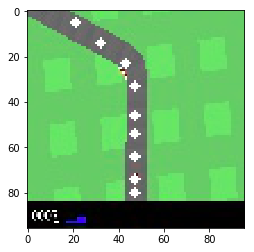

In [10]:
i=0
N=10
frame=cv2.imread('car_lane.jpg')
i2t=image_to_traj(N=10)
[crops,cxs,cys,hh]=i2t.run(frame)
#crops,cxs,cys=get_points(segment,N)
for x,y,crop in zip(cxs,cys,crops):
    img = cv2.circle(frame,(x,i+y), 2, (255,255,255), -1)
    print('x,y :',x,y+i,end=' ')
    i+=N
    
plt.imshow(img,cmap='gray',vmin=0,vmax=255)
plt.show()

In [71]:
# Draw the lines
if hough is not None:
        for i in range(0, len(hough)):
            l = hough[i][0]
            _ss=cv2.line(canny, (l[0], l[1]), (l[2], l[3]), (255,255,255), 1, cv.LINE_AA)

In [72]:
plt.imshow(nst)

In [73]:
#cv2.imwrite(nst,'car_lane.jpg')

TypeError: bad argument type for built-in operation

In [49]:
#len(hough)
_ss.shape

(96, 96)